The Euclidean distance transform of an image computes the distance of every pixel at $\mathbf{x}$ to a designated target region $T$:

$$d(\mathbf{x}) = \min_{\mathbf{t}\in T} \sqrt{ \sum_i (x_i - t_i)^2  }$$

For example, here's the Euclidean distance transfer to a couple of regions:

In [35]:
# preample
import numpy as np
import matplotlib.pyplot as plt; 
from IPython.display import display
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'png')

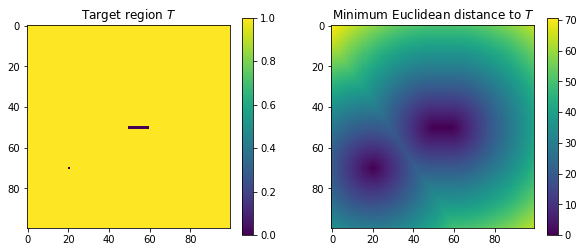

In [36]:
# plot example
from skimage import io
import scipy.ndimage as ndimage

Nx = 100;
Ny = 100;
mask = np.ones((Ny,Nx))
mask[50,50:60] = 0
mask[70,20] = 0
plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.imshow(mask); plt.colorbar(); 
plt.title('Target region $T$');

edt = ndimage.distance_transform_edt(mask)
plt.subplot(1,2,2); plt.imshow(edt); plt.colorbar();
plt.title('Minimum Euclidean distance to $T$');

## Geodesic distance
What if we wanted to take into account in our distance calculation that some areas are harder to transverse than others. For example, there's a swamp or hill, which hinders your movement or you need to move up or down as well as horizontally. The generalized distance where the measure of the distance varies from point to point is called the geodesic distance, and Euclidean distance transform on images can be generalized to geodesic distance transform. 

The geodesic distance to a pixel at $\mathbf{x}$ is defined as minimum length curve $\mathbf{x}(t)$ from the target region $T$ to that pixel:

$$d(\mathbf{x}(t_1)) = \min_{\mathbf{x}(t), \mathbf{x}(t_0) \in T}\int_{t_0}^{t_1} \sqrt{ g_{ij} \frac{\partial x_i}{\partial t} \frac{\partial x_j}{\partial t} } \mathrm{d}t,$$

where the metric tensor $g_{ij}$ the measure of local distance in different directions. This reduces to the Euclidean distance when $g_{11} = g_{22} = 1$ and $g_{21} = g_{12} = 0$ hold. For example on a swamp, we would like to have $g_{11} = g_{22} > 1$ to express that it is harder to transerse than normally, and on a hilly terrain with height map $h(x, y)$ we would have $g_{11} = 1 + \big(\frac{\partial h}{\partial x}\big)^2$, $g_{22} = 1 + \big(\frac{\partial h}{\partial y}\big)^2$, and $g_{12} = g_{21} = \frac{\partial h}{\partial x}\frac{\partial h}{\partial y}$ to take the slopes into account.

Let us take the hilly terrain as our example the discrete setting of an image. Then, to transverse from pixel to pixel horizontally or vertically, one would travel the distance 
$$ d(\mathbf{x}_{i,j}, \mathbf{x}_{i+1,j}) = \sqrt{1 + \big(h(\mathbf{x}_{i,j}) - h(\mathbf{x}_{i+1,j})\big)^2}$$
holds, and diagonally 
$$ d(\mathbf{x}_{i,j}, \mathbf{x}_{i+1,j+1}) = \sqrt{2 + \big(h(\mathbf{x}_{i,j}) - h(\mathbf{x}_{i+1,j+1})\big)^2}$$
holds. Again, these would reduce to the Euclidean distance if the heights at the pixels were the same.

The applications of the geodesic distance transform have been studied in https://www.microsoft.com/en-us/research/publication/geodesic-image-and-video-editing/

## The algorithm
To compute the geodesic distance transform of an image, we scan image the in four different orders while keeping track of the minimum accumulated geodesic distance to each pixel from the target region. That is, the first scan is from top-left to bottom-right, and we accumulate the distances at the pixels $\mathbf{x}_{i+1,j}$, $\mathbf{x}_{i,j+1}$, and $\mathbf{x}_{i+1,j+1}$ from that of at $\mathbf{x}_{i,j}$ so that for example
$$d(\mathbf{x}_{i+1,j}) = d(\mathbf{x}_{i,j}) + d(\mathbf{x}_{i,j}, \mathbf{x}_{i+1,j}) $$
holds. Once the initial scan is done, we scan in different orders, for example from top-right to bottom-left, and update the distance at $\mathbf{x}_{i,j}$ only if it is smaller the the previous accumulated distance $d(\mathbf{x}_{i,j})$. Here's the whole thing:

In [37]:
# return the geodesic distance to pixels indicated by mask, given a height map height
def geodesic_distance_transform(mask, height):    
    Nx = mask.shape[1]
    Ny = mask.shape[0]
    
    # initial distance is inifity execpt where the mask is zero
    M = np.inf 
    dist = M*np.ones(mask.shape) 
    dist[(mask < 1) & (mask >= 0)] = mask[(mask < 1) & (mask >= 0)]
    
    def scan(dist, mask, height):
        Nx = dist.shape[1]
        Ny = dist.shape[0]
            
        for i in np.arange(0, Ny):
            for j in np.arange(0, Nx):
                if i == 0 and j == 0:
                    continue
                if mask[i,j] == -1:
                    continue
                
                d = M*np.ones(5)
                d[0] = dist[i,j] # previous minimum from the last scan
                # compute the distances by approaching the target pixel from different directions
                if i > 0:
                    d[1] = dist[i-1,j] + np.sqrt(1 + (height[i,j] - height[i-1,j])**2 )                
                if j > 0:
                    d[2] = dist[i,j-1] + np.sqrt(1 + (height[i,j] - height[i,j-1])**2 )                    
                if i > 0 and j > 0:
                    d[3] = dist[i-1,j-1] + np.sqrt(2 + (height[i,j] - height[i-1,j-1])**2 )                
                if j < Nx-1 and i > 0:    
                    d[4] = dist[i-1,j+1] + np.sqrt(2 + (height[i,j] - height[i-1,j+1])**2 )
            
                # select the miniumum distance
                dist[i,j] = np.amin(d)
            
        return dist

    dist = scan(dist, mask, height)
    dist = scan(dist[::-1,::-1], mask[::-1,::-1], height[::-1,::-1])
    dist = dist[::-1,::-1]
    dist = scan(dist[:,::-1], mask[:,::-1], height[:,::-1])
    dist = dist[:,::-1]
    dist = scan(dist[::-1,:], mask[::-1,:], height[::-1,:])
    dist = dist[::-1,:]
    dist[dist==M] = -1
    
    return dist

## Example

As an example height map let us taken an actual height map from Finnish National land survey open data at http://www.maanmittauslaitos.fi/en/e-services/open-data-file-download-service downloaded on January 2018.


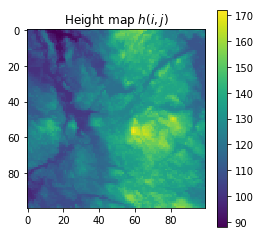

In [38]:
from skimage import io

# create image from ascii data
#data = np.loadtxt(fname='M4211E.asc',  skiprows=6)
#from skimage.transform import resize
#height = resize(data, (data.shape[0] / 30, data.shape[1] / 30), mode='reflect')
#io.imsave('height.png', height.astype('uint8'))

height = io.imread('height.png').astype(float)

plt.figure(figsize=(4,4))
plt.imshow(height); plt.colorbar();
plt.title('Height map $h(i,j)$');


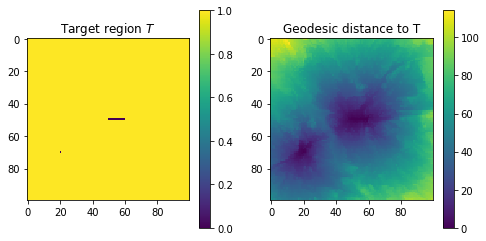

In [39]:
plt.figure(figsize=(2*4,4))
plt.subplot(1,2,1); plt.imshow(mask); plt.colorbar(); 
plt.title('Target region $T$');

dist = geodesic_distance_transform(mask, height)
plt.subplot(1,2,2); plt.imshow(dist); plt.colorbar();
plt.title('Geodesic distance to T');

## Conculsion

The geodesic distance transform has a variety of interesting applications, and it is fairly easy to implement. Parallelized GPU impelemtations have also been studied. 

This Jupyter notebook is available [here](https://github.com/mattipellikka/blog/blob/master/geodesic_distance_transform/geodesic_distance_transform.ipynb).